<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/ProblemsWithAlpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install "git+https://github.com/Karasiari/HuGraphFinal.git"

  Cloning https://github.com/Karasiari/HuGraphFinal.git to /tmp/pip-req-build-gfb3ne54
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/HuGraphFinal.git /tmp/pip-req-build-gfb3ne54
  Resolved https://github.com/Karasiari/HuGraphFinal.git to commit 6919d225817954368ed4a6aa3d785adb967b246b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hugraphfin: filename=hugraphfin-0.1.0-py3-none-any.whl size=66299 sha256=af2b15bc47eb77621acb15ae64a7ff39999e22a07ffa2d901a46d04ae15b425c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ipt0bhn/wheels/46/83/89/572a6db8e6320eb877bf6ced236fa61f993538a12c5e43c72e
Successfully built hugraphfin


In [2]:
# чтобы не падал ecos
%pip install ecos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 11.6 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from graph_exps.exp import *

def gammas_test(graph: HuGraphForExps, additional_resources, allocation_types, available_demand_volumes):
  def get_edge_key(edge):
    u, v = edge
    return (min(u, v), max(u, v))
  edges_with_alphas_unkeyd = compute_alpha_for_all_edges(graph)
  edges_with_alphas = [(get_edge_key(edge), alpha) for edge, alpha in edges_with_alphas_unkeyd]
  edges_with_alphas_dict = {edge: alpha for edge, alpha in edges_with_alphas}
  route_result, demands, _, multidigraph = graph.solve_mcf()
  expanded_graphs = {}
  for allocation_type in allocation_types:
    expanded_graphs[allocation_type]  = expand_network_for_type(multidigraph, edges_with_alphas, additional_resources, allocation_type)
  edges_for_remaining_networks = get_edges_for_remaining_networks(expanded_graphs, remaining_networks_pref="all", route_result=route_result, demands=demands)
  _, remaining_networks_gammas_by_type, _ = allocation_test(expanded_graphs, route_result, demands, edges_for_remaining_networks, tries_for_allocation=1, epsilon=1.2, available_volumes=available_demand_volumes, random_seed=None)
  gammas_dict = {}
  for allocation_type, remaining_networks_gammas in remaining_networks_gammas_by_type.items():
    gammas_dict[allocation_type] = {}
    for edge, remaining_network_gamma in remaining_networks_gammas:
      gammas_dict[allocation_type][f'gamma/alpha for failed {edge}'] = (round(remaining_network_gamma, 2), round(edges_with_alphas_dict[edge], 5))
  gammas_df = pd.DataFrame(gammas_dict).T
  return gammas_df

def transform_df(df):
    df = df.copy()
    df['type'] = df.index.get_level_values(0)
    df_filtered = df[df['type'] != 'alpha'].copy()

    # Находим значения alpha для деления
    alpha_row = df[df['type'] == 'alpha']
    alpha_dict = {}

    if not alpha_row.empty:
        for col in df.columns:
            if col != 'type':
                val = alpha_row.iloc[0][col]
                if isinstance(val, tuple):
                    alpha_dict[col] = val[0] if len(val) > 0 else 1
                else:
                    alpha_dict[col] = val

    def transform_row(row):
        second_values = []

        # Собираем все вторые значения
        for col in df.columns:
            if col != 'type' and col in alpha_dict:
                val = row[col]
                if isinstance(val, tuple) and len(val) > 1:
                    second_values.append(val[1])

        # Если нет вторых значений, возвращаем как есть
        if not second_values:
            return row.to_dict()

        # Вычисляем квартили
        second_arr = np.array(second_values)
        q10, q20, q30, q40, q50, q60, q70, q80, q90 = np.nanpercentile(second_arr, [10, 20, 30, 40, 50, 60, 70, 80, 90])

        # Функция для определения группы
        def get_group(x):
            if np.isnan(x):
                return 0
            if x <= q10:
                return 1
            elif x <= q20:
                return 2
            elif x <= q30:
                return 3
            elif x <= q40:
                return 4
            elif x <= q50:
                return 5
            elif x <= q60:
                return 6
            elif x <= q70:
                return 7
            elif x <= q80:
                return 8
            elif x <= q90:
                return 9
            else:
                return 10

        # Преобразуем значения
        new_row = {'type': row['type']}
        for col in df.columns:
            if col != 'type' and col in alpha_dict:
                val = row[col]
                if isinstance(val, tuple) and len(val) > 1:
                    new_first = alpha_dict[col] / val[0] if val[0] != 0 else np.nan
                    new_second = get_group(val[1])
                    new_row[col] = (new_first, new_second)
                else:
                    new_row[col] = val

        return new_row

    # Применяем преобразование
    result_data = []
    for idx, row in df_filtered.iterrows():
        result_data.append(transform_row(row))

    result_df = pd.DataFrame(result_data, index=df_filtered.index)
    return result_df

def agg_to_groups(result_df):
    results = []

    for idx, row in result_df.iterrows():
        # Создаем словарь для хранения данных по группам
        group_data = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}

        # Собираем первые значения по группам
        for col in result_df.columns:
            if col != 'type':
                val = row[col]
                if isinstance(val, tuple) and len(val) >= 2:
                    group = val[1]
                    first_num = val[0]
                    if group in group_data and not pd.isna(first_num):
                        group_data[group].append(first_num)

        # Вычисляем средние по группам
        row_result = {'type': row['type']}
        for group in range(1, 11):
            group_vals = group_data[group]
            row_result[f'group_{group}'] = np.mean(group_vals) if group_vals else np.nan

        results.append(row_result)

    # Создаем финальный датафрейм (ВНЕ цикла!)
    grouped_df = pd.DataFrame(results, index=result_df.index)
    return grouped_df

def plot_experiment_groups(experiment_dfs, methods_col='type', groups_prefix='group_'):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import numpy as np

    # Собираем все уникальные методы
    all_methods = []
    for df in experiment_dfs:
        all_methods.extend(df[methods_col].unique())
    unique_methods = sorted(set(all_methods))

    # Собираем все уникальные группы и сортируем численно (1-10)
    group_columns = []
    for df in experiment_dfs:
        group_cols = [col for col in df.columns if col.startswith(groups_prefix)]
        group_columns.extend(group_cols)

    # Извлекаем номера групп и сортируем по числам
    group_numbers = []
    for col in set(group_columns):
        try:
            num = int(col.replace(groups_prefix, ''))
            group_numbers.append((num, col))
        except ValueError:
            group_numbers.append((float('inf'), col))  # Если не число, в конец

    group_numbers.sort()  # Сортируем по числовому ключу
    group_columns = [col for _, col in group_numbers]

    # Создаем цветовую палитру для методов
    method_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_methods)))
    method_color_dict = dict(zip(unique_methods, method_colors))

    # Настройки сетки графиков (по 2 в строке)
    n_groups = len(group_columns)
    n_cols = 2
    n_rows = (n_groups + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(5*n_cols, 4*n_rows),
                            squeeze=False)
    axes = axes.flatten()

    # Для каждой группы
    for idx, group_col in enumerate(group_columns):
        ax = axes[idx]

        # Собираем данные по методам для текущей группы
        x_positions = []
        y_values = []
        colors = []
        labels_for_legend = set()

        for exp_idx, exp_df in enumerate(experiment_dfs):
            for method in unique_methods:
                if method in exp_df[methods_col].values:
                    group_value = exp_df.loc[exp_df[methods_col] == method, group_col].values
                    if len(group_value) > 0 and not np.isnan(group_value[0]):
                        x_positions.append(exp_idx)
                        y_values.append(group_value[0])
                        colors.append(method_color_dict[method])

                        if method not in labels_for_legend:
                            ax.scatter([], [], color=method_color_dict[method],
                                     s=60, label=method)  # Уменьшен размер
                            labels_for_legend.add(method)

        # Строим scatter plot с меньшими точками
        if x_positions:
            ax.scatter(x_positions, y_values,
                      c=colors, s=60, alpha=0.8, edgecolors='white', linewidth=0.5)

        # Добавляем горизонтальную линию на y=1.0
        ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7)

        # Настройки графика
        ax.set_xlabel('Эксперимент', fontsize=11)
        ax.set_ylabel('Значение', fontsize=11)
        group_num = group_col.replace(groups_prefix, '')
        ax.set_title(f'Группа {group_num}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Настройка оси X
        ax.set_xticks(np.arange(len(experiment_dfs)))
        ax.set_xticklabels([f'Exp {i+1}' for i in range(len(experiment_dfs))],
                          fontsize=9)

        # Настройка оси Y с гарантированным отображением y=1.0
        if y_values:
            y_min, y_max = min(y_values), max(y_values)

            # Расширяем пределы, чтобы гарантированно видеть y=1.0
            y_min = min(y_min, 1.0)
            y_max = max(y_max, 1.0)

            # Добавляем отступы
            y_range = y_max - y_min
            if y_range == 0:
                padding = 0.5
            else:
                padding = y_range * 0.15

            ax.set_ylim(y_min - padding, y_max + padding)
        else:
            # Если нет данных, все равно показываем область вокруг 1.0
            ax.set_ylim(0.8, 1.2)

        # Добавляем подпись значения на оси Y для y=1.0
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

        # Делаем сетку более заметной
        ax.grid(True, alpha=0.2, axis='both', linestyle=':', linewidth=0.5)

    # Скрываем неиспользуемые подграфики
    for idx in range(n_groups, len(axes)):
        axes[idx].axis('off')

    # Общая легенда для методов
    handles = [Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=method_colors[i],
                      markersize=8, label=method)  # Уменьшен размер в легенде
               for i, method in enumerate(unique_methods)]

    # Добавляем линию y=1.0 в легенду
    handles.append(Line2D([0], [0], color='red', linestyle='--',
                         linewidth=2, label='y = 1.0'))

    fig.legend(handles=handles, loc='upper center',
               bbox_to_anchor=(0.5, 1.02),
               ncol=min(len(unique_methods) + 1, 6),
               fontsize=10,
               frameon=True,
               fancybox=True,
               shadow=True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Место для легенды
    plt.show()

In [ ]:
from graph_exps.traffic_generation.generation_for_exp import generate_own_traffic
from graph_exps.SNRBA_generation.generation import generate_snr_ba_graph
from graph_exps.readers.hugraph_reader import read_hu_graphs

available_demand_volumes = ((1, 0.9), (2, 0.1))
capacity_value = 80.0
additional_resources = [capacity_value] * 3
allocation_types = ['alpha', 'random_alpha', 'random','alpha_mid_random', 'alpha_high_random']
additional_resources.sort(reverse=True)

all_dfs = []
for i in range(8):
  snr_ba_graph = generate_snr_ba_graph(num_nodes=27+i, capacity_value=capacity_value, random_seed=42+i)
  adj_graph_alpha, traffic_graph_alpha =  generate_own_traffic(
      snr_ba_graph,
      available_demand_volumes,
      generation_type="alpha_with_sa",
      generation_params={"alpha_target": 0.35, "epsilon": 0.025, "median_weight_for_initial": 20, "var_for_initial": 1, "multi_max": 5, "t": 0.5}
  )
  graph_for_exp_alpha = HuGraphForExps(adj_graph_alpha, traffic_graph_alpha)
  df = gammas_test(graph_for_exp_alpha, additional_resources, allocation_types, available_demand_volumes)
  result_df = agg_to_groups(transform_df(df))
  all_dfs.append(result_df)

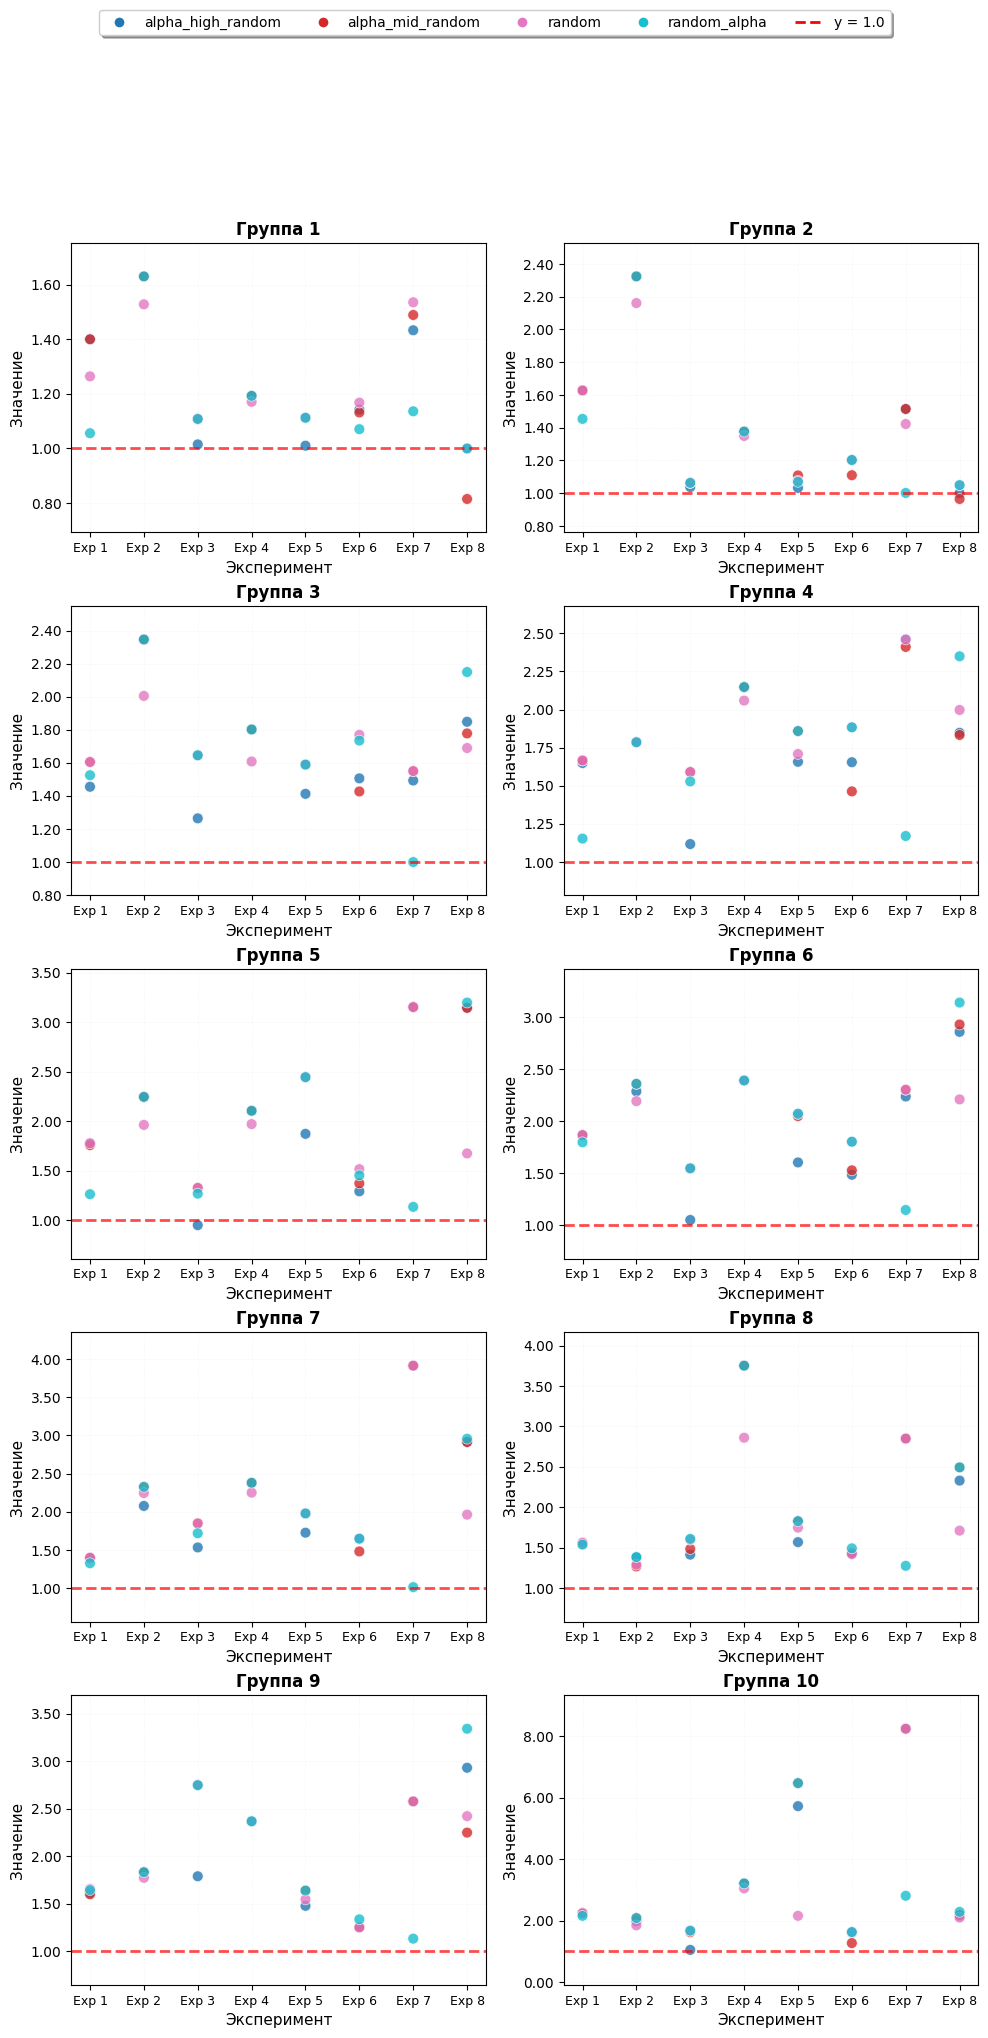

In [15]:
plot_experiment_groups(all_dfs)

In [19]:
merged_df = pd.concat(
    [df.assign(experiment_id=f'exp_{i+1}') for i, df in enumerate(all_dfs)],
    ignore_index=True
)
group_cols = [col for col in merged_df.columns if col.startswith('group_')]
filtered_df = merged_df[merged_df[group_cols].lt(1.0).any(axis=1)]

In [20]:
filtered_df

,type,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,experiment_id
11,alpha_high_random,1.015021,1.037436,1.264471,1.118121,0.949798,1.049775,1.533850,1.415568,1.789410,1.046771,exp_3
30,alpha_mid_random,0.815085,0.964720,1.778093,1.833275,3.143897,2.928323,2.913329,2.494220,2.248517,2.177510,exp_8


**Черновик**

In [72]:
import pandas as pd
import numpy as np
from graph_exps.exp import *

def add_test(graph: HuGraphForExps, additional_resources, allocation_types, available_demand_volumes):
  def get_edge_key(edge):
    u, v = edge
    return (min(u, v), max(u, v))
  edges_with_alphas_unkeyd = compute_alpha_for_all_edges(graph)
  edges_with_alphas = [(get_edge_key(edge), alpha) for edge, alpha in edges_with_alphas_unkeyd]
  edges_with_alphas_dict = {edge: alpha for edge, alpha in edges_with_alphas}
  route_result, demands, _, multidigraph = graph.solve_mcf()
  expanded_graphs = {}
  for allocation_type in allocation_types:
    expanded_graphs[allocation_type]  = expand_network_for_type(multidigraph, edges_with_alphas, additional_resources, allocation_type)
  edges_for_remaining_networks = get_edges_for_remaining_networks(expanded_graphs, remaining_networks_pref="all", route_result=route_result, demands=demands)
  algorithm_results, _, volume_to_reroute_by_type = allocation_test(expanded_graphs, route_result, demands, edges_for_remaining_networks, tries_for_allocation=30, epsilon=1.2, available_volumes=available_demand_volumes, random_seed=None)
  add_dict = {}
  allocation_seen = {}
  for allocation_type, algorithm_result in algorithm_results:
    if allocation_seen.get(allocation_type, False):
      num = allocation_seen[allocation_type] + 1
      allocation_seen[allocation_type] = num
    else:
      num = 1
      allocation_seen[allocation_type] = num
    add_dict[(allocation_type, num)] = {}
    for edge, add_by_edge in algorithm_result[2].items():
      add_dict[(allocation_type, num)][f'add/alpha for failed {edge}'] = (add_by_edge, round(edges_with_alphas_dict[edge], 5))
    add_dict[(allocation_type, num)]['rerouted volume ratio'] = round(algorithm_result[1] / volume_to_reroute_by_type[allocation_type], 2)
  add_df = pd.DataFrame(add_dict).T
  return add_df

In [55]:
def transform_df_add(df):
    df = df.copy()
    df['type'] = df.index.get_level_values(0)

    def transform_row(row):
        second_values = []

        # Собираем все вторые значения
        for col in df.columns:
            if col != 'type' and col != 'rerouted volume ratio':
                val = row[col]
                if isinstance(val, tuple) and len(val) > 1:
                    second_values.append(val[1])

        # Если нет вторых значений, возвращаем как есть
        if not second_values:
            return row.to_dict()

        # Вычисляем квартили
        second_arr = np.array(second_values)
        q25, q50, q75 = np.nanpercentile(second_arr, [25, 50, 75])

        # Функция для определения группы
        def get_group(x):
            if np.isnan(x):
                return 0
            if x <= q25:
                return 1
            elif x <= q50:
                return 2
            elif x <= q75:
                return 3
            else:
                return 4

        # Преобразуем значения
        new_row = {'type': row['type'], 'rerouted volume ratio': row['rerouted volume ratio']}
        for col in df.columns:
            if col != 'type' and col != 'rerouted volume ratio':
                val = row[col]
                if isinstance(val, tuple) and len(val) > 1:
                    new_first = val[0]
                    new_second = get_group(val[1])
                    new_row[col] = (new_first, new_second)
                else:
                    new_row[col] = val

        return new_row

    # Применяем преобразование
    result_data = []
    for idx, row in df.iterrows():
        result_data.append(transform_row(row))

    result_df = pd.DataFrame(result_data, index=df.index)
    return result_df

def calculate_group_ratios(result_df):
    results = []

    for idx, row in result_df.iterrows():
        # Создаем словарь для хранения данных по группам
        group_data = {1: [], 2: [], 3: [], 4: []}

        # Собираем первые значения по группам
        for col in result_df.columns:
            if col != 'type' and col != 'rerouted volume ratio':
                val = row[col]
                if isinstance(val, tuple) and len(val) >= 2:
                    group = val[1]
                    first_num = val[0]
                    if group in group_data and not pd.isna(first_num):
                        group_data[group].append(first_num)

        # Вычисляем суммы по группам и общую сумму
        group_sums = {}
        total_sum = 0

        for group in range(1, 5):
            group_vals = group_data[group]
            if group_vals:
                group_sum = np.sum(group_vals)
                group_sums[group] = group_sum
                total_sum += group_sum
            else:
                group_sums[group] = 0

        # Вычисляем доли (отношение суммы группы к общей сумме)
        row_result = {'type': row['type'], 'rerouted volume ratio': row['rerouted volume ratio']}
        for group in range(1, 5):
            if total_sum > 0:
                ratio = group_sums[group] / total_sum
                row_result[f'group_{group}'] = round(ratio, 2)
            else:
                row_result[f'group_{group}'] = np.nan

        results.append(row_result)

    # Создаем финальный датафрейм
    grouped_df = pd.DataFrame(results, index=result_df.index)
    return grouped_df

In [ ]:
from graph_exps.traffic_generation.generation_for_exp import generate_own_traffic
from graph_exps.SNRBA_generation.generation import generate_snr_ba_graph
from graph_exps.readers.hugraph_reader import read_hu_graphs

available_demand_volumes = ((1, 0.9), (2, 0.1))
capacity_value = 80.0
additional_resources = [capacity_value] * 3
allocation_types = ['alpha', 'random_alpha', 'random', 'random_mid_alpha']
additional_resources.sort(reverse=True)

all_dfs = []
for i in range(1):
  snr_ba_graph = generate_snr_ba_graph(num_nodes=25, capacity_value=capacity_value, random_seed=42)
  adj_graph_alpha, traffic_graph_alpha =  generate_own_traffic(
      snr_ba_graph,
      available_demand_volumes,
      generation_type="alpha_with_sa",
      generation_params={"alpha_target": 0.35, "epsilon": 0.025, "median_weight_for_initial": 20, "var_for_initial": 1, "multi_max": 5, "t": 0.5}
  )
  graph_for_exp_alpha = HuGraphForExps(adj_graph_alpha, traffic_graph_alpha)
  df = add_test(graph_for_exp_alpha, additional_resources, allocation_types, available_demand_volumes)
  result_df = calculate_group_ratios(transform_df_add(df))
  all_dfs.append(result_df)

In [74]:
Df = all_dfs[0]

/tmp/ipython-input-1188570174.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


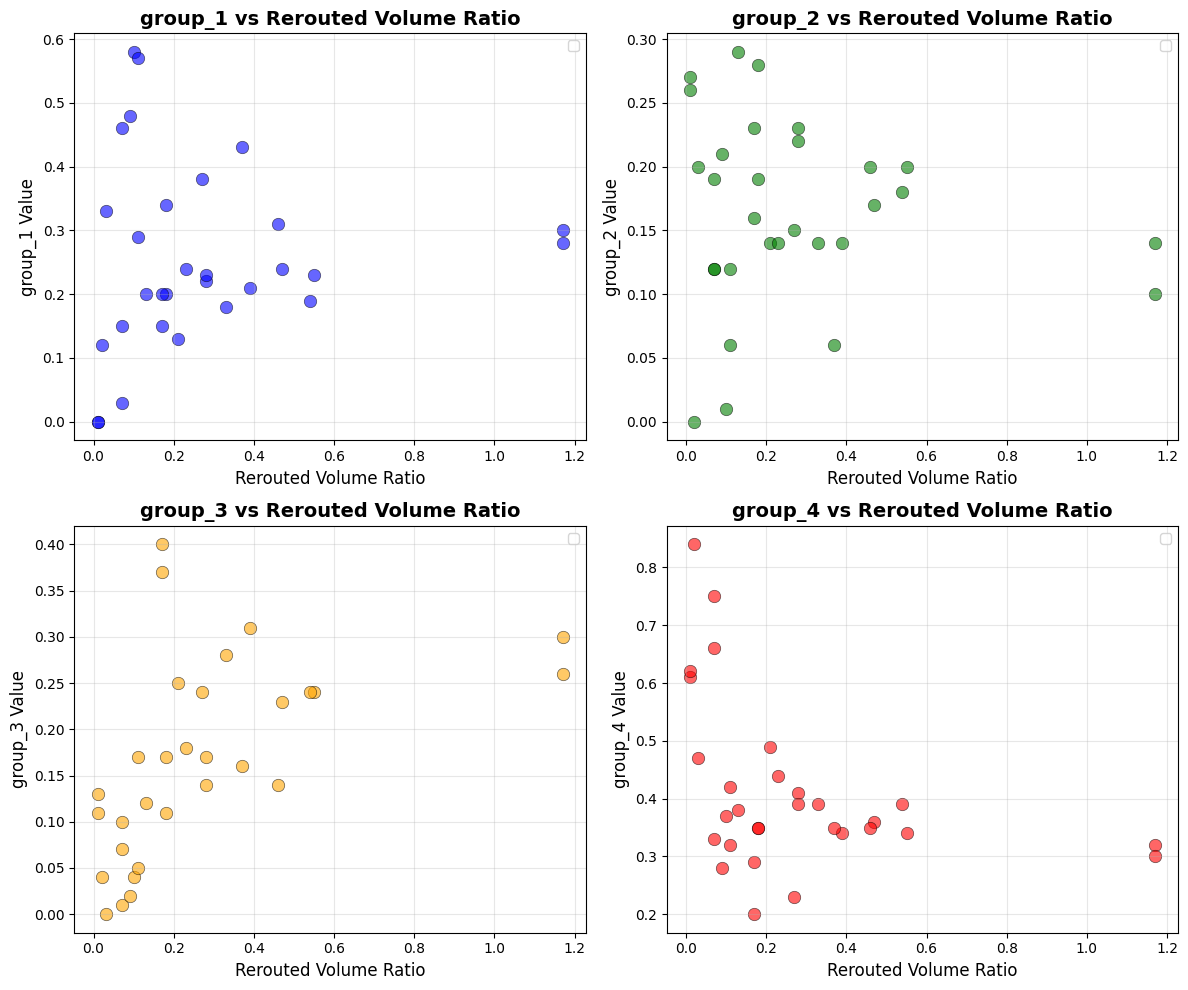

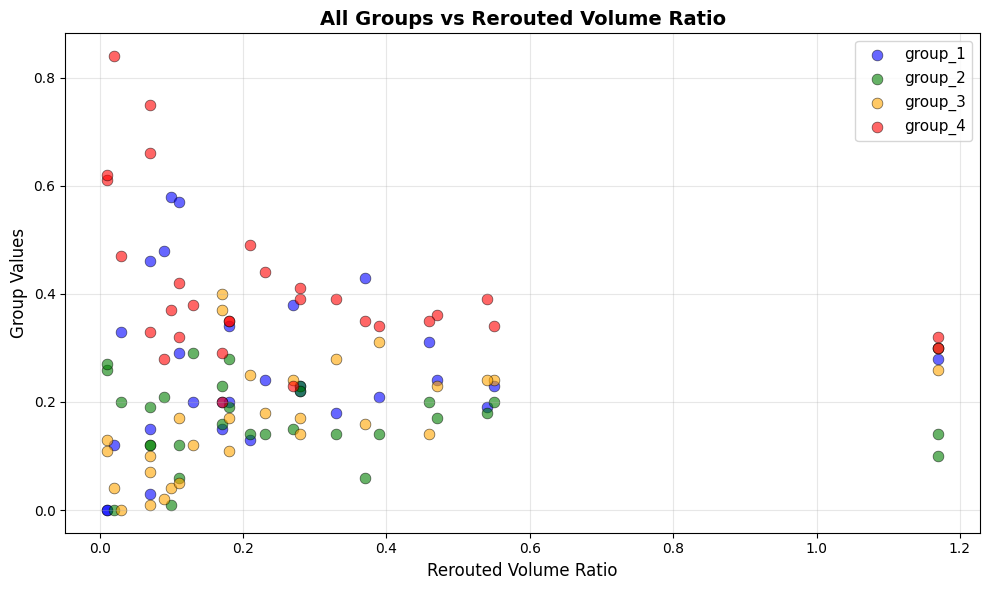

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def plot_group_scatter(df):
    """
    Создает scatterplot для каждой группы (group_1-group_4)
    в зависимости от rerouted volume ratio
    """

    # Проверяем наличие необходимых столбцов
    required_cols = ['rerouted volume ratio']
    group_cols = [f'group_{i}' for i in range(1, 5)]

    for col in group_cols:
        if col in df.columns:
            required_cols.append(col)

    # Проверяем, что есть хотя бы одна группа
    if len(required_cols) < 2:
        print("Не найдены столбцы групп (group_1..group_4)")
        return

    # Создаем подграфики
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Цвета для разных групп
    colors = ['blue', 'green', 'orange', 'red']

    # Строим scatterplot для каждой группы
    for idx, (group_col, ax) in enumerate(zip(group_cols, axes)):
        if group_col in df.columns:
            # Получаем данные для текущей группы
            x_data = df['rerouted volume ratio']
            y_data = df[group_col]

            # Строим scatterplot
            scatter = ax.scatter(x_data, y_data,
                                c=colors[idx],
                                alpha=0.6,
                                edgecolors='black',
                                linewidth=0.5,
                                s=80)

            # Настройки графика
            ax.set_xlabel('Rerouted Volume Ratio', fontsize=12)
            ax.set_ylabel(f'{group_col} Value', fontsize=12)
            ax.set_title(f'{group_col} vs Rerouted Volume Ratio', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)

            # Добавляем легенду с трендом
            ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    # Дополнительно: все группы на одном графике
    fig2, ax2 = plt.subplots(figsize=(10, 6))

    for idx, group_col in enumerate(group_cols):
        if group_col in df.columns:
            x_data = df['rerouted volume ratio']
            y_data = df[group_col]

            ax2.scatter(x_data, y_data,
                       c=colors[idx],
                       alpha=0.6,
                       s=60,
                       label=group_col,
                       edgecolors='black',
                       linewidth=0.5)

    ax2.set_xlabel('Rerouted Volume Ratio', fontsize=12)
    ax2.set_ylabel('Group Values', fontsize=12)
    ax2.set_title('All Groups vs Rerouted Volume Ratio', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)

    plt.tight_layout()
    plt.show()

# Использование функции
plot_group_scatter(Df[Df['type']=='alpha'])

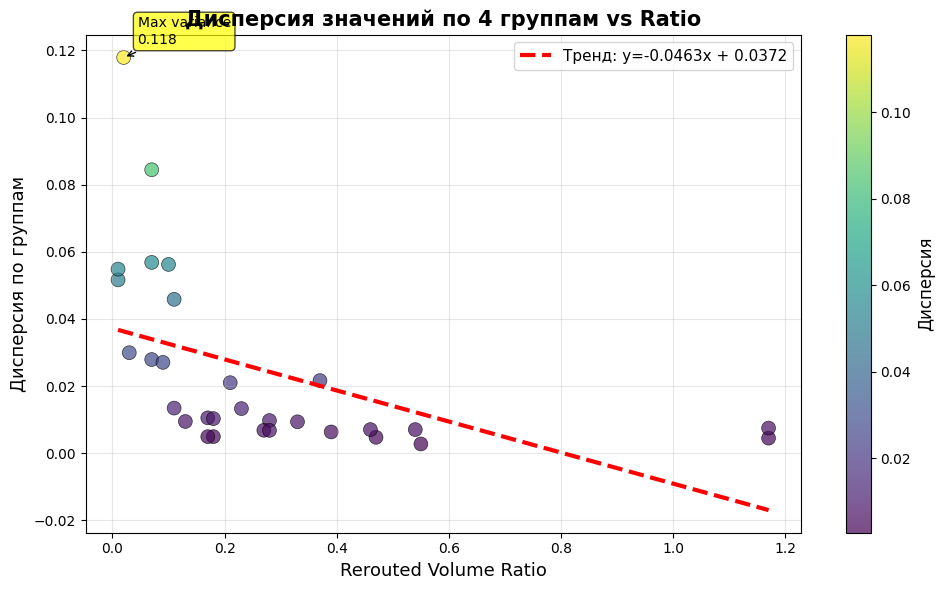


Статистика дисперсии (n=30):
  Средняя дисперсия: 0.0245
  Медианная дисперсия: 0.0104
  Максимальная дисперсия: 0.1179
  Минимальная дисперсия: 0.0028
  Корреляция с Ratio: -0.4886


In [82]:
def plot_single_variance_scatter(df):
    """
    Один scatterplot дисперсии по группам от ratio
    """

    # Проверяем группы
    group_cols = [f'group_{i}' for i in range(1, 5)]
    available_groups = [col for col in group_cols if col in df.columns]

    if len(available_groups) < 2:
        print(f"Нужно минимум 2 группы, найдено {len(available_groups)}")
        return

    # Рассчитываем дисперсию для каждой строки
    variances = []
    ratios = []

    for idx, row in df.iterrows():
        if pd.isna(row['rerouted volume ratio']):
            continue

        # Собираем значения групп
        group_values = []
        for group_col in available_groups:
            if not pd.isna(row[group_col]):
                group_values.append(row[group_col])

        # Если есть хотя бы 2 значения, считаем дисперсию
        if len(group_values) >= 2:
            variance = np.var(group_values)
            variances.append(variance)
            ratios.append(row['rerouted volume ratio'])

    if len(ratios) == 0:
        print("Нет данных для построения графика")
        return

    # Создаем график
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot
    scatter = ax.scatter(ratios, variances,
                        c=variances,  # Цвет по значению дисперсии
                        cmap='viridis',
                        alpha=0.7,
                        s=100,
                        edgecolors='black',
                        linewidth=0.5)

    # Добавляем colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Дисперсия', fontsize=12)

    # Линия тренда
    if len(ratios) > 1:
        z = np.polyfit(ratios, variances, 1)
        p = np.poly1d(z)

        # Сортируем для плавной линии
        sort_idx = np.argsort(ratios)
        ratios_sorted = np.array(ratios)[sort_idx]
        variances_sorted = np.array(variances)[sort_idx]

        ax.plot(ratios_sorted, p(ratios_sorted),
               'r--', linewidth=3,
               label=f'Тренд: y={z[0]:.4f}x + {z[1]:.4f}')

    # Настройки графика
    ax.set_xlabel('Rerouted Volume Ratio', fontsize=13)
    ax.set_ylabel('Дисперсия по группам', fontsize=13)
    ax.set_title(f'Дисперсия значений по {len(available_groups)} группам vs Ratio',
                fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)

    # Добавляем аннотации для выбросов
    if len(variances) > 0:
        max_var_idx = np.argmax(variances)
        ax.annotate(f'Max variance\n{variances[max_var_idx]:.3f}',
                   xy=(ratios[max_var_idx], variances[max_var_idx]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='black'))

    plt.tight_layout()
    plt.show()

    # Статистика
    print(f"\nСтатистика дисперсии (n={len(variances)}):")
    print(f"  Средняя дисперсия: {np.mean(variances):.4f}")
    print(f"  Медианная дисперсия: {np.median(variances):.4f}")
    print(f"  Максимальная дисперсия: {np.max(variances):.4f}")
    print(f"  Минимальная дисперсия: {np.min(variances):.4f}")

    if len(ratios) > 1:
        correlation = np.corrcoef(ratios, variances)[0, 1]
        print(f"  Корреляция с Ratio: {correlation:.4f}")

# Использование
plot_single_variance_scatter(Df[Df['type']=='alpha'])